In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import scipy
import scipy.interpolate as interp


In [2]:
MV = 7*1
x0, y0, z0 = 0, 0, 0

def B_d(x,y,z, MV, x0, y0, z0):
    r = np.sqrt((x-x0)**2+ (y-y0)**2 + (z-z0)**2)
#     Bx = 5/3.*MV*(z-z0)*(x-x0)*r**(-7)
#     By = 5/3.*MV*(z-z0)*(y-y0)*r**(-7)
#     Bz = -1/3.*MV*r**(-5) + 5/3.*MV*(z-z0)**2*r**(-7)
    Bx = MV*(z-z0)*(x-x0)*r**(-5)
    By = MV*(z-z0)*(y-y0)*r**(-5)
    Bz = -1/3.*MV*r**(-3) + MV*(z-z0)**2*r**(-5)
    return np.array([Bx, By, Bz])
B_d(0,0,2.3, MV, x0, y0, z0)

array([0.        , 0.        , 0.38355114])

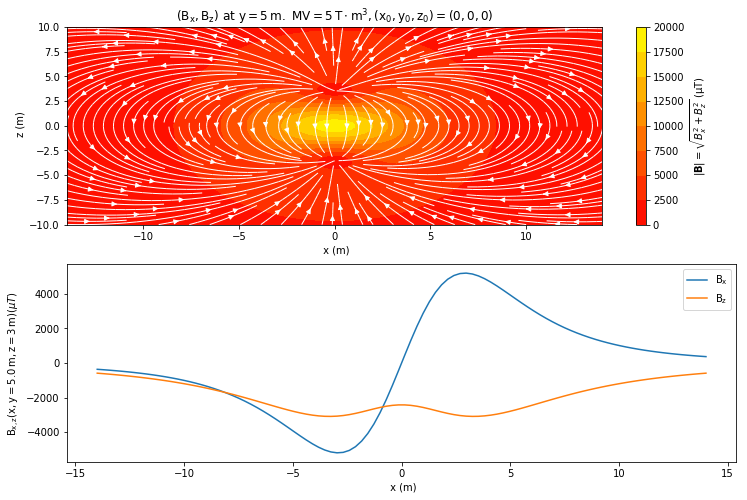

In [4]:

NL =  100
# x_lin = np.linspace(8, 14, NL)
# z_lin = np.linspace(-2, 5, NL)
x_lin = np.linspace(-14, 14, NL)
z_lin = np.linspace(-10, 10, NL)
x_mesh, z_mesh = np.meshgrid(x_lin, z_lin)
Bd_x_mesh, Bd_y_mesh, Bd_z_mesh = B_d(x_mesh, 5, z_mesh, MV, x0, y0, z0)*1e6

fig0 = plt.figure(figsize=(12,8))
ax0 = fig0.add_subplot(211)
str0 = ax0.streamplot(x_mesh, z_mesh, Bd_x_mesh, Bd_z_mesh, linewidth=1,density=1.8,color='white')
cp0 = ax0.contourf(x_mesh, z_mesh, np.sqrt(Bd_x_mesh**2 + Bd_z_mesh**2), cmap=cm.autumn)
cb0 = fig0.colorbar(cp0, ax=ax0,label='$|\mathbf{B}|=\sqrt{B_x^2+B_z^2}\,\,\mathsf{(\mu T)}$')

B_d_0_x, B_d_0_y, B_d_0_z =  B_d(x_lin, 5, 3, MV, x0, y0, z0)*1e6
ax1 = fig0.add_subplot(212)
ax1.plot(x_lin, B_d_0_x, label='$\mathsf{B_x}$')
ax1.plot(x_lin, B_d_0_z, label='$\mathsf{B_z}$')
ax1.legend()
ax0.set_title('$\mathsf{(B_x, B_z)\,\, at\,\, y=5\,m.\,\,MV=5\,T\cdot m^3, (x_0,y_0,z_0)=(0,0,0)}$')
ax0.set_xlabel(' x (m)')
ax0.set_ylabel(' z (m)')

ax1.set_xlabel(' x (m)')
ax1.set_ylabel('$\mathsf{B_{x,z}(x,y=5.0\,m, z=3\,m)} (\mu T)$')

fig0.savefig('dipole_overview')
# fig0.savefig('dipole_zoomin_2')

In [5]:
# df = pd.read_csv('data_export/map_export_[-141.8,98.2]_[-327.2,192.8]_[-100.0,100.0].csv') 
df = pd.read_csv('data_export/map_export_[-141.8,98.2]_[-327.2,192.8]_[-100.0,300.0].csv')
# df = pd.read_csv('data_export/map_export_[-141.8,98.2]_[-327.2,192.8]_[-200.0,400.0].csv')
df['x_SI'] = df.x*1e-2
df['y_SI'] = df.y*1e-2
df['z_SI'] = df.z*1e-2
df['Bx_SI'] = df.B_x*1e-4
df['By_SI'] = df.B_y*1e-4
df['Bz_SI'] = df.B_z*1e-4


In [122]:
from scipy.optimize import least_squares
from scipy.optimize import dual_annealing
from scipy.optimize import minimize
from scipy.optimize import rosen, differential_evolution

# par0 = np.array([5, -20, 5.0, 0.1, 1e-6, 2e-6, 2e-6]) # MV, x0, y0, z0, Bx0, By0, Bz0
par0 = np.array([ 5.23092762e+00, -1.88704633e+01, -9.96669656e+00,  2.18295713e+00,2.05182559e-05, -1.51629197e-05, -4.29513663e-05])


def res(par):
    dBx = B_d(df.x_SI, df.y_SI, df.z_SI, par[0], par[1], par[2], par[3])[0] + par[4] - df.Bx_SI
    dBy = B_d(df.x_SI, df.y_SI, df.z_SI, par[0], par[1], par[2], par[3])[1] + par[5]- df.By_SI
    dBz = B_d(df.x_SI, df.y_SI, df.z_SI, par[0], par[1], par[2], par[3])[2] +par[6] - df.Bz_SI
    res_av = np.average(np.sqrt(dBx**2 + dBy**2+ dBz**2))
    return res_av

result_1 = least_squares(res, par0)
result_2_CG = minimize(res, par0, method='CG')
result_2_SLSQP = minimize(res, par0, method='SLSQP')
# result_2_NM = minimize(res, par0, method='Nelder-Mead') # failed 
# result_2_P = minimize(res, par0, method='Powell') #failed
result_2_TNC =  minimize(res, par0, method='TNC')  
result_2_BFGS = minimize(res, par0, method='BFGS') 
result_2_LBFGSB = minimize(res, par0, method='L-BFGS-B') 


In [118]:
bounds = [(0.5,20), (-1, -50), (-10, 10), (-10, 10), (-1e-4, 1e-4), (-1e-4, 1e-4), (-1e-4, 1e-4)]
result_dev = differential_evolution(res, bounds)
# minimize?

In [119]:
result_dev

     fun: array(0.)
     jac: array([0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 15330
     nit: 145
 success: True
       x: array([ 5.23092762e+00, -1.88704633e+01, -9.96669656e+00,  2.18295713e+00,
        2.05182559e-05, -1.51629197e-05, -4.29513663e-05])

In [123]:
result_2_TNC

     fun: 1.816331786623945e-05
     jac: array([-7.10186304e-08, -2.17415062e-07,  3.63244320e-07, -2.64751328e-07,
        2.43862789e-04,  6.54620848e-04, -6.97132912e-04])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 4
     nit: 1
  status: 1
 success: True
       x: array([ 5.23092762e+00, -1.88704633e+01, -9.96669656e+00,  2.18295713e+00,
        2.07374794e-05, -1.51738247e-05, -4.31884505e-05])

In [124]:
result_2_CG


     fun: 1.816332023377487e-05
     jac: array([-7.64975994e-08, -2.18828745e-07,  3.61085085e-07, -2.40207783e-07,
        1.53225747e-05,  1.42725912e-06,  2.13256430e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 606
     nit: 4
    njev: 66
  status: 2
 success: False
       x: array([ 5.23092762e+00, -1.88704633e+01, -9.96669656e+00,  2.18295713e+00,
        2.07337578e-05, -1.51805631e-05, -4.31852474e-05])

In [83]:
result_dev

In [125]:
par_opt = result_2_TNC.x
# par_opt = result_dev.x
print par_opt

[ 5.23092762e+00 -1.88704633e+01 -9.96669656e+00  2.18295713e+00
  2.07374794e-05 -1.51738247e-05 -4.31884505e-05]


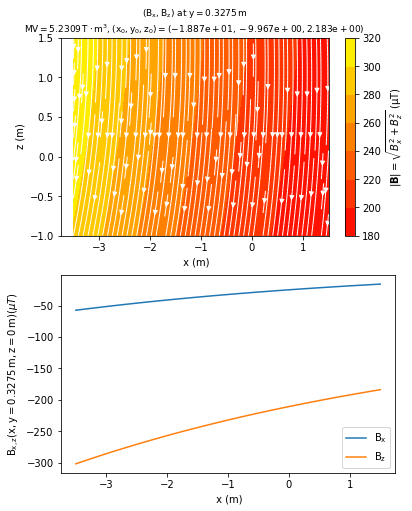

In [126]:

y_cut = 0.3275


NL =  100
x_lin = np.linspace(-3.5, 1.5, NL)
z_lin = np.linspace(-1, 1.5, NL)
x_mesh, z_mesh = np.meshgrid(x_lin, z_lin)
Bd_x_mesh, Bd_y_mesh, Bd_z_mesh = B_d(x_mesh, y_cut, z_mesh,par_opt[0], par_opt[1], par_opt[2], par_opt[3])
Bd_x_mesh = Bd_x_mesh + par_opt[4]
Bd_y_mesh = Bd_y_mesh + par_opt[5]
Bd_z_mesh = Bd_z_mesh + par_opt[6]


fig1 = plt.figure(figsize=(6,8))
ax10 = fig1.add_subplot(211)
str1 = ax10.streamplot(x_mesh, z_mesh, Bd_x_mesh, Bd_z_mesh, linewidth=1,density=1.8,color='white')
cp1 = ax10.contourf(x_mesh, z_mesh, np.sqrt(Bd_x_mesh**2 + Bd_z_mesh**2)*1e6, cmap=cm.autumn)
cb1 = fig1.colorbar(cp1, ax=ax10, label='$|\mathbf{B}|=\sqrt{B_x^2+B_z^2}\,\,\mathsf{(\mu T)}$')

B_d_0_x, B_d_0_y, B_d_0_z =  B_d(x_lin, y_cut, 0, par_opt[0],par_opt[1], par_opt[2], par_opt[3])
B_d_0_x = B_d_0_x + par_opt[4]
B_d_0_y = B_d_0_y + par_opt[5]
B_d_0_z = B_d_0_z + par_opt[6]

ax11 = fig1.add_subplot(212)
ax11.plot(x_lin, B_d_0_x*1e6, label='$\mathsf{B_x}$')
ax11.plot(x_lin, B_d_0_z*1e6, label='$\mathsf{B_z}$')
ax11.legend()
ax10.set_title('$\mathsf{(B_x, B_z)\,\, at\,\, y=%.4f\,m}$\n$\mathsf{MV=%.4f\,T\cdot m^3, (x_0,y_0,z_0)=(%.3e,%.3e,%.3e)}$' %(y_cut, par_opt[0],par_opt[1],par_opt[2],par_opt[3]), fontsize=9)
ax10.set_xlabel(' x (m)')
ax10.set_ylabel(' z (m)')

ax11.set_xlabel(' x (m)')
ax11.set_ylabel('$\mathsf{B_{x,z}(x,y=%.4f\,m, z=0\,m)} (\mu T)$' %y_cut)

# fig0.savefig('dipole_overview')
fig1.savefig('dipole_fit_xz')

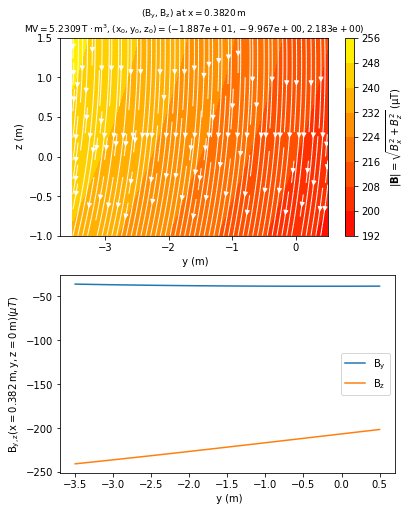

In [128]:

# x_cut = -0.018
x_cut = 0.3820


NL =  100
y_lin = np.linspace(-3.5, 0.5, NL)
z_lin = np.linspace(-1, 1.5, NL)
y_mesh, z_mesh = np.meshgrid(y_lin, z_lin)
Bd_x_mesh, Bd_y_mesh, Bd_z_mesh = B_d(x_cut, y_mesh, z_mesh,par_opt[0], par_opt[1], par_opt[2], par_opt[3])
Bd_x_mesh = Bd_x_mesh + par_opt[4]
Bd_y_mesh = Bd_y_mesh + par_opt[5]
Bd_z_mesh = Bd_z_mesh + par_opt[6]


fig2 = plt.figure(figsize=(6,8))
ax20 = fig2.add_subplot(211)
str2 = ax20.streamplot(y_mesh, z_mesh, Bd_x_mesh, Bd_z_mesh, linewidth=1,density=1.8,color='white')
cp2 = ax20.contourf(y_mesh, z_mesh, np.sqrt(Bd_x_mesh**2 + Bd_z_mesh**2)*1e6, cmap=cm.autumn)
cb2 = fig2.colorbar(cp2, ax=ax20, label='$|\mathbf{B}|=\sqrt{B_x^2+B_z^2}\,\,\mathsf{(\mu T)}$')

B_d_0_x, B_d_0_y, B_d_0_z =  B_d(x_cut, y_lin, 0, par_opt[0],par_opt[1], par_opt[2], par_opt[3])
B_d_0_x = B_d_0_x + par_opt[4]
B_d_0_y = B_d_0_y + par_opt[5]
B_d_0_z = B_d_0_z + par_opt[6]

ax21 = fig2.add_subplot(212)
ax21.plot(y_lin, B_d_0_y*1e6, label='$\mathsf{B_y}$')
ax21.plot(y_lin, B_d_0_z*1e6, label='$\mathsf{B_z}$')
ax21.legend()
ax20.set_title('$\mathsf{(B_y, B_z)\,\, at\,\, x=%.4f\,m}$\n$\mathsf{MV=%.4f\,T\cdot m^3, (x_0,y_0,z_0)=(%.3e,%.3e,%.3e)}$' %(x_cut, par_opt[0],par_opt[1],par_opt[2],par_opt[3]), fontsize=9)
ax20.set_xlabel(' y (m)')
ax20.set_ylabel(' z (m)')

ax21.set_xlabel(' y (m)')
ax21.set_ylabel('$\mathsf{B_{y,z}(x=%.3f\,m,y,z=0\,m)} (\mu T)$' %x_cut)

# fig0.savefig('dipole_overview')
fig2.savefig('dipole_fit_yz_3820')
# fig2.savefig('dipole_fit_yz_-0180')